# Mother Machine Data Pipeline for Symbiodinium cells

## Prerequsities: 
- your raw data is in tiff-file format (can be converted with eg. bioformats)
- you (manually) create a folder on your computer where you want to store all your results

### Import packages

In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector


from PIL import Image

from skimage import io
from skimage.color import rgba2rgb, rgb2gray
from skimage.util import img_as_float, img_as_ubyte
from skimage.io import imread, imsave

from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks

import imageio
import napari
from tqdm.notebook import tqdm 


### Output folder
- First create a folder where you want to save all your results on your computer and then input the path to that folder below in the cell below
- note: this will create all results from a tiff raw data file in that folder, if you have mutiple image series for analysis make sure you change the name of the original_tiff_image_series for each run of pipeline

In [4]:
output_folder = r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all"

### Specify path to tiff-image-series (raw-data)
your tiff file of raw image data for which you want to analyse

In [5]:
original_tiff_image_series = r"C:\Users\micha\Desktop\Master_Project\ORIGINAL_TIFF_Series_rawdata\tiff_file_converted_2.tiff"

### View the image series in Napari
here you can view your raw tiff image file in Napari to make sure it looks good

In [9]:
original_image_series = io.imread(original_tiff_image_series)
viewer = napari.view_image(original_image_series, colormap='gray', name ='Original Image Series')

### Create a folder for a tiff-image-series data 
Creates a folder within the output folder for all results coming from the raw data

In [6]:
# Extract base name (filename without extension) from the original_tiff_image_series path
base_name = os.path.splitext(os.path.basename(original_tiff_image_series))[0]

# Create a folder within the output_folder using the base name
result_folder = os.path.join(output_folder, f"MM_pipeline_results_{base_name}")

# Create the result folder if it doesn't exist
os.makedirs(result_folder, exist_ok=True)

# Now, result_folder contains the path to the folder you want to use for the pipeline results
print(f"Pipeline results for this image series will be saved in: {result_folder}")

Pipeline results for this image series will be saved in: C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted_2


### Metadata

In [9]:
# Read TIFF file using imageio
tiff_frames = imageio.volread(original_tiff_image_series)

# Extract Specific Frame (e.g., the first frame):
first_frame_data = tiff_frames[0]

# Check shape and number of channels
height, width = first_frame_data.shape[:2]
num_channels = 1 if len(first_frame_data.shape) == 2 else first_frame_data.shape[2]

print(f'Height: {height}, Width: {width}, Number of Channels: {num_channels}')

Height: 2160, Width: 2560, Number of Channels: 1


In [5]:
subfolder_name_flipped_images = "individual_flipped_image_tiffs"
subfolder_path_flipped_images = os.path.join(result_folder, subfolder_name_flipped_images)


### Download tiff-image series as separate frames/images
download separate images as tiffs into specified output folder and flips them so traps are vertical for downstream processing

In [21]:
# Ensure that result_folder exists
os.makedirs(result_folder, exist_ok=True)

# Create a subfolder within result_folder called "individual_flipped_image"
subfolder_name_flipped_images = "individual_flipped_image_tiffs"
subfolder_path_flipped_images = os.path.join(result_folder, subfolder_name_flipped_images)
os.makedirs(subfolder_path_flipped_images, exist_ok=True)

# Read TIFF file using imageio
tiff_frames = imageio.volread(original_tiff_image_series)

# Total number of frames in the TIFF file
num_frames = tiff_frames.shape[0]
print(f'Number of total frames: {num_frames}')

# Use tqdm for the loop to show a progress bar
for frame_to_display in tqdm(range(num_frames), desc='Processing Frames', unit='frame'):
    # Extract Specific Frame:
    tiff_data = tiff_frames[frame_to_display]

    # Ensure the image is in uint8 format
    tiff_data = (tiff_data / np.max(tiff_data) * 255).astype(np.uint8)

    # Flip the image 90 degrees to the left
    flipped_tiff_data = np.rot90(tiff_data, k=-1)

    # Save the flipped TIFF frame using imageio
    output_path_flipped = os.path.join(subfolder_path_flipped_images, f'original_frame_{frame_to_display + 1}.tiff')
    imageio.imwrite(output_path_flipped, flipped_tiff_data)



Number of total frames: 392


Processing Frames:   0%|          | 0/392 [00:00<?, ?frame/s]

In [8]:
subfolder_name_flipped_images = "individual_flipped_image_tiffs"

subfolder_path_flipped_images = os.path.join(result_folder, subfolder_name_flipped_images)


### Manual cropping of growth traps/channels for each image 
Manually draw boxes around traps (first frame of the tiff file), the coordinates for these will be saved and then used to crop all subsequent traps

In [9]:
matplotlib.use('Qt5Agg')  # Use 'Qt5Agg' backend

# Get a list of all files in the folder
list_flipped_tiffs = os.listdir(subfolder_path_flipped_images)

# Select the first TIFF image file (assuming it's an image)
if list_flipped_tiffs:
    first_tiff_image_path = os.path.join(subfolder_path_flipped_images, list_flipped_tiffs[0])
    print("First image path:", first_tiff_image_path)
else:
    print("No files found in the specified folder.")

# Load the TIFF image using imageio
first_tiff_image_data = imageio.imread(first_tiff_image_path)


class ManualTrapCropping:
    def __init__(self, image_data):
        self.image = image_data
        self.fig, self.ax = plt.subplots()
        self.ax.imshow(self.image, cmap='gray')  # Display the image as grayscale
        self.rectangles = {}
        self.current_trap_index = 1
        self.first_rect_coords = None
        self.fixed_size = None
        self.rs = RectangleSelector(self.ax, self.on_rectangle_select,
                                     minspanx=5, minspany=5, spancoords='pixels', interactive=True)
        plt.connect('key_press_event', self.on_key_press)

    def on_rectangle_select(self, eclick, erelease):
        if self.fixed_size is None:
            # Store the dimensions of the first rectangle
            self.fixed_size = (erelease.xdata - eclick.xdata, erelease.ydata - eclick.ydata)

        # Use the fixed size for subsequent rectangles
        x_min, y_min = eclick.xdata, eclick.ydata
        x_max, y_max = x_min + self.fixed_size[0], y_min + self.fixed_size[1]

        # Save the rectangle coordinates globally
        global trap_coordinates_dict
        trap_coordinates_dict[self.current_trap_index] = (x_min, y_min, x_max, y_max)

    def on_key_press(self, event):
        if event.key == 'enter':
            # Draw the rectangle on the plot
            rect_coords = trap_coordinates_dict[self.current_trap_index]
            x_min, y_min, x_max, y_max = rect_coords
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
            self.ax.add_patch(rect)
            plt.draw()

            # Increment the trap index for the next rectangle
            self.current_trap_index += 1

        elif event.key == 'q':
            # Print the final dictionary of rectangles
            print("Trap coordinates:", trap_coordinates_dict)
            plt.close()

# Initialize the dictionary globally
trap_coordinates_dict = {}

# Create an instance of ManualTrapCropping
manual_cropping = ManualTrapCropping(first_tiff_image_data)
plt.show()


First image path: C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted_2\individual_flipped_image_tiffs\original_frame_1.tiff


C:\Users\micha\AppData\Local\Temp\ipykernel_6560\2575903934.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  first_tiff_image_data = imageio.imread(first_tiff_image_path)

KeyboardInterrupt



In [32]:
print(trap_coordinates_dict)

def calculate_rectangle_size(trap_coordinates_dict):
    sizes = {}

    for trap_index, coord in trap_coordinates_dict.items():
        x1, y1, x2, y2 = coord
        width = x2 - x1
        height = y2 - y1
        sizes[trap_index] = {'width': width, 'height': height}

    return sizes

# Example usage
rectangle_sizes = calculate_rectangle_size(trap_coordinates_dict)

for trap_index, size in rectangle_sizes.items():
    print(f"Trap {trap_index} Size: Width = {size['width']}, Height = {size['height']}")


{1: (90.69570085087344, 815.0485893416931, 276.9921630094045, 2556.2039856695033), 2: (359.3925212718318, 822.2138378862521, 545.6889834303629, 2563.369234214062), 3: (631.6719659650698, 825.7964621585315, 817.9684281236009, 2566.9518584863417), 4: (907.534034930587, 825.7964621585315, 1093.8304970891181, 2566.9518584863417), 5: (1165.482982534707, 829.379086430811, 1351.779444693238, 2570.5344827586214), 6: (1448.510300044783, 815.0485893416931, 1634.806762203314, 2556.2039856695033), 7: (1713.6244961934617, 822.2138378862521, 1899.9209583519928, 2563.369234214062), 8: (1967.990819525302, 818.6312136139725, 2154.287281683833, 2559.7866099417824)}
Trap 1 Size: Width = 186.29646215853109, Height = 1741.1553963278102
Trap 2 Size: Width = 186.29646215853109, Height = 1741.15539632781
Trap 3 Size: Width = 186.29646215853109, Height = 1741.1553963278102
Trap 4 Size: Width = 186.29646215853109, Height = 1741.1553963278102
Trap 5 Size: Width = 186.29646215853109, Height = 1741.1553963278104
T

### Crops traps based on the stored coordinates of the manual selection and visualises in plots
This cell is an example usage and is only for visualization of the cropping

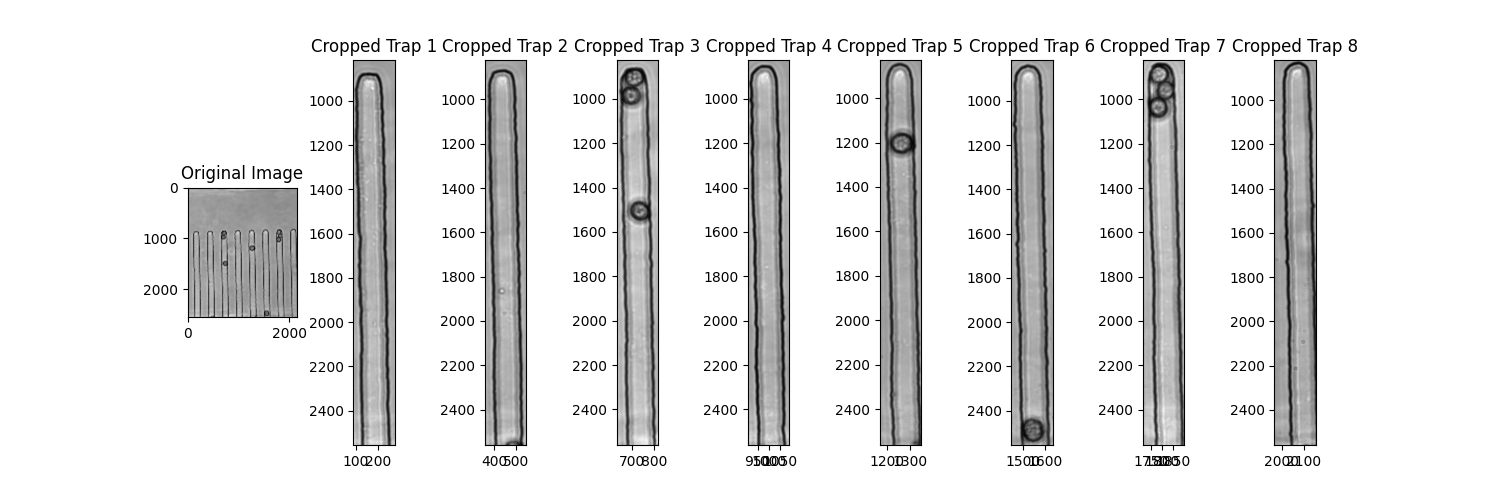

In [24]:
%matplotlib widget

def crop_visualise_image(image_path, trap_coordinates_dict):
    # Read the TIFF image using imageio
    image = io.imread(image_path)

    # Create subplots to display the original and cropped traps
    num_traps = len(trap_coordinates_dict)
    fig, axes = plt.subplots(1, num_traps + 1, figsize=(15, 5))

    # Display the original image in grayscale
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original Image")

    # Crop the image based on the rectangles and display each cropped trap
    for i, (trap_index, rect_coords) in enumerate(trap_coordinates_dict.items(), start=1):
        x_min, y_min, x_max, y_max = map(int, rect_coords)  # Ensure integer values
    
        # Ensure coordinates are within the image boundaries
        x_min = max(0, x_min)
        x_max = min(image.shape[1], x_max)
        y_min = max(0, y_min)
        y_max = min(image.shape[0], y_max)
    
        # Crop the image
        cropped_trap = image[y_min:y_max, x_min:x_max]
    
        # Display the cropped trap in grayscale
        axes[i].imshow(cropped_trap, cmap='gray', extent=(x_min, x_max, y_max, y_min))
        axes[i].set_title(f"Cropped Trap {trap_index}")

    plt.show()

# Example usage with trap_coordinates_dict
crop_visualise_image(first_tiff_image_path, trap_coordinates_dict)


### Crop the traps and save to folders
Crops the traps based on the manual selection and saves each trap in different folders which correspond to trap position 

In [25]:
# Function to crop traps without visualization
def crop_image_function(image_path, trap_coordinates_dict):
    # Read the TIFF image using imageio
    image = io.imread(image_path)
    
    # Crop the image based on the rectangles and display each cropped trap
    for trap_index, rect_coords in trap_coordinates_dict.items():
        x_min, y_min, x_max, y_max = map(int, rect_coords)  # Ensure integer values
    
        # Ensure coordinates are within the image boundaries
        x_min = max(0, x_min)
        x_max = min(image.shape[1], x_max)
        y_min = max(0, y_min)
        y_max = min(image.shape[0], y_max)
    
        # Crop the image
        cropped_trap = image[y_min:y_max, x_min:x_max]
        
        yield trap_index, cropped_trap

In [26]:
#Function to save cropped traps

def process_directory(input_directory, output_directory, trap_coordinates_dict):
    # Create a subfolder in the output directory for the cropped traps
    output_subfolder = os.path.join(output_directory, "Individual_cropped_traps_directory")
    os.makedirs(output_subfolder, exist_ok=True)

    # Create separate folders for each key in trap_coordinates_dict
    for trap_index in trap_coordinates_dict:
        trap_folder = os.path.join(output_subfolder, f"Cropped_traps_position_{trap_index}")
        os.makedirs(trap_folder, exist_ok=True)

    # Iterate through files in the input directory with tqdm
    for filename in tqdm(os.listdir(input_directory), desc="Processing files"):
        if filename.endswith(".tiff"):
            # Construct the full path to the image file
            image_path = os.path.join(input_directory, filename)
       
            # Use the crop_image function to crop the image
            for trap_index, cropped_trap in crop_image_function(image_path, trap_coordinates_dict):
                trap_folder = os.path.join(output_subfolder, f"Cropped_traps_position_{trap_index}")
                output_filename = os.path.join(trap_folder, f"{filename[:-5]}_cropped_trap_pos_{trap_index}.tiff")  # Adjust extension if needed
                io.imsave(output_filename, cropped_trap)
# Example usage
input_directory_croptrap = subfolder_path_flipped_images
output_directory_croptrap = result_folder
process_directory(input_directory_croptrap, output_directory_croptrap, trap_coordinates_dict)


Processing files:   0%|          | 0/392 [00:00<?, ?it/s]

In [ ]:
import os
import napari
import numpy as np
from PIL import Image
from tqdm import tqdm

def resize_image(img, target_width):
    scale_factor = target_width / img.width
    resized_img = img.resize((int(img.width * scale_factor), int(img.height * scale_factor)))
    return resized_img

def stack_images_vertically(folder_path, target_width):
    images = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".tiff"):
            image_path = os.path.join(folder_path, filename)
            img = Image.open(image_path)
            resized_img = resize_image(img, target_width)
            images.append(np.array(resized_img))

    stacked_image = np.vstack(images)
    return stacked_image

def stack_images_across_positions(output_subfolder, target_width, trap_coordinates_dict):
    stacked_images_positions = {trap_index: [] for trap_index in trap_coordinates_dict}

    for trap_index in tqdm(trap_coordinates_dict, desc="Stacking images positions"):
        trap_folder = os.path.join(output_subfolder, f"Cropped_traps_position_{trap_index}")

        if os.path.exists(trap_folder):
            for position in range(1, len(stacked_images_positions[trap_index]) + 1):
                image_stack = stack_images_vertically(trap_folder, target_width)
                stacked_images_positions[trap_index].append(image_stack)

    return stacked_images_positions

# Path to the output directory where cropped traps are saved
output_subfolder = os.path.join(output_directory_croptrap, "Individual_cropped_traps_directory")

# Set a common target width for resizing
target_width = 500

# Stack images for each position and store the results
stacked_images_positions = stack_images_across_positions(output_subfolder, target_width, trap_coordinates_dict)

# Display stacked images in Napari
with napari.gui_qt():
    viewer = napari.Viewer()

    for trap_index, stacked_images in stacked_images_positions.items():
        for position, stack in enumerate(stacked_images, start=1):
            viewer.add_image(stack, name=f"Trap {trap_index} Position {position}")
